# Planning

Business problem:
- The financial institution has an estimated churn retention rate of 28%/year.
- A new retention goal was announced for next year, which is 40%. To achieve this, the customer retention team needs a churn prediction model.
- The model must be at least 55% effective in identifying true churners, while avoiding false positives.
- This way, the retention team will act using the model to reverse at least 80% of churns, which results in 44% retention, reaching the goal.

Problem type: Binary Classification
- The 'abandono_clientes.csv' dataset contains 10k rows and 13 features, which is enough to create a supervised machine learning model using a frequentist approach.
- To deal with this churn problem, some classification models with different approaches will be created, and the best one will be used.

Evaluation metric: F1 score 
- F1 score will be the metric used with cross-validation, considering:
    - The business team needs a good balance between finding actual churners (recall) and avoiding false alarms (precision). 
    - Focuses on minority class (churners) performance without being skewed by majority class dominance (unbalanced dataset: 20% churned).

Methodology: CRISP-DM
- Cross Industry Standard Process for Data Mining methodology will be used, being cyclical and flexible, in order to take advantage of best market practices.

Project deliverables:
- EDA Notebook with:
    - Statistical analysis of data.
    - Business Insights from variables.
- Modeling Notebook with: 
    - Churn prediction model with a baseline > 0.55 on test data: 55% effectiveness in identifying true churners.
    - Model Explainability.
    - Business and financial results.
- CSV file with:
    - 'abandono_result.csv' file, being the model predictions from 'abandono_teste.csv'.

# Imports

In [132]:
import pandas as pd
import numpy as np 
import inflection
import warnings
import joblib

import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import shapiro
import shap

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, classification_report

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Functions

In [4]:
# Rename dataframe columns (snake_case) 
class RenameDfColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.copy().rename(columns=lambda x: inflection.underscore(x))


# Remove features from dataset
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns if columns else []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=self.columns)    


# Create new features from existing ones
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()

      # Create age_group feature
        X['age_group'] = pd.cut(
            X['age'],
            bins=[17, 30, 37, 45, 63, float('inf')], 
            labels=['18-30', '31-37', '38-45', '46-63', '64+'], 
            right=True
        )
        
        # Create geo_gender feature
        X['geo_gender'] = X['geography'] + '_' + X['gender']

        # Create balance_group feature
            # if balance = 0 or middle of distribution, then 0, else its on tail, then 1
        X['balance_group'] = X['balance'].apply(lambda x: 0 if x == 0 or (50000 <= x <= 200000) else 1)

        # Create product_group feature
        X['product_group'] = X['num_of_products'].apply(
            lambda x: 'C' if x == 2 else 'B' if x == 1 else 'A' if x in [3, 4] else None
        )

        return X

## Load Data

In [5]:
df_raw = pd.read_csv('../data/train/abandono_clientes.csv')
df_raw.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


## Data Split

In [6]:
train, test = train_test_split( df_raw, train_size=0.80, test_size=0.20, random_state=98, stratify=df_raw.Exited, shuffle=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train Size: {len(train):} ({len(train)/len(df_raw):.1%})')
print(f'Test Size: {len(test):} ({len(test)/len(df_raw):.1%})')

#Created to be used on final pipeline:
X_train_raw = train.drop('Exited', axis = 1)
y_train_raw = train.Exited 
X_test_raw = test.drop('Exited', axis = 1) 
y_test_raw = test.Exited 

Train Size: 8000 (80.0%)
Test Size: 2000 (20.0%)


## Data Dictionary

|  Column   | Meaning   |
| :-------  | :------- |
| **RowNumber** | Record number |
| **CustomerId** | Customer ID |
| **Surname** | Customer's last name |
| **CreditScore** | Customer's credit score |
| **Geography** | Customer's country of residence |
| **Gender** | Costumer's gender |
| **Age** | Costumer's age |
| **Tenure** | Number of years that the customer has been a client of the institution |
| **Balande** | Ammount of money the client have on it's account |
| **NumOfProducts** | Number of products that a customer has purchased through the institution |
| **HasCrCard** | Denotes whether or not a customer has a credit card with the institution. [1 - has credit card; 0 - dosen't have credit card] |
| **IsActiveMember** | Denotes whether client is active or not. [1 - active; 0 - non active ] |
| **EstimatedSalary** | Client's estimated anual salary |
| **Exited** | Denotes whether the client has an account at the institution. [1 - Client has exited instittion; 0 - client dosen't have exited institution] |

# Data Cleaning

## Rename Features

In [7]:
#Rename columns (snake_case) with Pipeline 
pipe_rename_features = Pipeline([
    ('rename_features', RenameDfColumns())
])
train = pipe_rename_features.fit_transform(train)
train.head(2)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,2603,15683521,Godfrey,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0
1,4606,15585599,Stone,530,France,Female,34,8,0.00,2,0,1,141872.52,0


## DTypes and Missings

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        8000 non-null   int64  
 1   customer_id       8000 non-null   int64  
 2   surname           8000 non-null   object 
 3   credit_score      8000 non-null   int64  
 4   geography         8000 non-null   object 
 5   gender            8000 non-null   object 
 6   age               8000 non-null   int64  
 7   tenure            8000 non-null   int64  
 8   balance           8000 non-null   float64
 9   num_of_products   8000 non-null   int64  
 10  has_cr_card       8000 non-null   int64  
 11  is_active_member  8000 non-null   int64  
 12  estimated_salary  8000 non-null   float64
 13  exited            8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


No missings, dtypes ok.

## Duplicates

In [9]:
# Get duplicate rows
train[train.duplicated()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No duplicated rows.

## Feature Filtering

Remove unnecessary features:

In [10]:
# Remove features with Pipeline
pipe_filter_features = Pipeline([
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname']))
])

# Filter Columns using Pipeline
train = pipe_filter_features.transform(train)
train[:1]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0


# Feature Engineering

In [11]:
# Split data from train and test
X_train = train.drop('exited', axis = 1) # will be used to inspect pipeline parts
X_test = test.drop('Exited', axis = 1)
y_train = train['exited']
y_test = test['Exited']
del train, test

Based on EDA notebook, these are the initial feature engineering ideas to improve model performance:

- geo_gender: Creates gender vs geography groups, resulting in a new feature that summarizes the information content of both.
- age_group: Create age groups from age, calibrating to make them balanced. In this way, in the case of ages that are underrepresented, the bin may make it easier for the model to recognize them. 
- balance_group: Create a binary indicator for balance: center vs tail (tail: except customers with a balance = 0, those with less than 50k and with more than 200k churned more vs rest).
- product_group: Create a scale for num_of_product: "C" for 2 products, "B" for 1 product, "A" for 3 or 4 products (3 groups), in order to create a kind of scale by churn level, helping models to identify churn.

They will be implemented through the FeatureEngineering class below in this cycle 1.

In [12]:
# Feature Engineering with Pipeline
pipe_feature_eng = Pipeline([
    ('feature_eng', FeatureEngineering())
])

X_train = pipe_feature_eng.fit_transform(X_train)
X_train[:2]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,age_group,geo_gender,balance_group,product_group
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,18-30,Germany_Male,0,C
1,530,France,Female,34,8,0.00,2,0,1,141872.52,31-37,France_Female,0,C


In [13]:
#Inspection - exemple of age_group:
X_train.age_group.value_counts(normalize=True)

age_group
31-37   0.31
38-45   0.28
18-30   0.20
46-63   0.18
64+     0.03
Name: proportion, dtype: float64

When inspecting the proportion of new features, with the exception of geo_gender, the others ended up unbalanced.

In this cycle 1, due to deadline restrictions, I will continue like this.

In cycle 2, I will statistically validate using the Kruskal-Wallis test, wich is non-parametric, and works well with small samples like this.

This way, I can identify which features have significant differences between groups, then decide if they may be included on project.

Other improvements on feature engineering for future cycles would be:
 - Increase the number of derived features in feature engineering, trying interactions and polynomials.
 - Running a clustering to identify natural groups of customers, and create a new feature using this labels.

# Data Preparation

Feature Scaling and Transformation will be applied to the dataset, to avoid biased results, accelerate training, and improve interpretability. 
- Feature Scaling: makes numerical features comparable, preventing dominance of larger-scale features, and iproves model convergence.
- Transformation: handles categorical data, fixes non-linear relationships and reduces data skewness.

## Feature Scaling

In [19]:
# Select numerical features 
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_num[:2]

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,balance_group
0,594,28,0,142574.71,2,1,0,129084.82,0
1,530,34,8,0.00,2,0,1,141872.52,0


Perform Shapiro-Wilk test on numerical features, to identify which are normally distributed.

In [23]:
print(f' Normal distribution: (True/False)') 
for feature in list(X_train_num.columns):
    sample_data = X_train_num[feature].sample(n=5000, random_state=42)
    stat, p = shapiro(sample_data)
    print(f' -{feature} --> {p > 0.05}')

 Normal distribution: (True/False)
 -credit_score --> False
 -age --> False
 -tenure --> False
 -balance --> False
 -num_of_products --> False
 -has_cr_card --> False
 -is_active_member --> False
 -estimated_salary --> False
 -balance_group --> False


Since features are not normally distributed, I will use MinMaxScaler.

In [24]:
# MinMaxScaler with Pipeline
pipe_numeric_scaling = Pipeline([
    ('numeric_scaling', MinMaxScaler())
])

## Transformations

In [25]:
#Select categorical features 
X_train_cat = X_train.select_dtypes(exclude=['int64', 'float64'])
X_train_cat[:2]

,geography,gender,age_group,geo_gender,product_group
0,Germany,Male,18-30,Germany_Male,C
1,France,Female,31-37,France_Female,C


In this cycle 1, due to deadline restrictions, I will use One Hot Encoding for all categorical features, since it preserves all category information, and benefits model interpretability. 

In the next cycle, I will apply more effective and specific transformations for each feature:
- Ordinal Encoding for age_group, highlighting the importance of group order.
- Binary Encoding for gender, since there are only two variations.
- Target Encoding for the others, being effective for categorical variables with a greater number of variations.

This brings benefits, such as:
- Reduction of the dimensionality of the dataset, caused now by One Hot Encoding, that increases the number of features.
- In a production scenario, for example in the age_group variable, each age group is transformed into a new feature. If there is a data drift, the behavior of one age group can pass to the next. If this next group has been removed by feature selection in the next step, and the model will no longer be able to identify this phenomenon.

In [27]:
# OneHotEncoder with Pipeline
pipe_categ_transform = Pipeline([
    ('categ_transform', OneHotEncoder(sparse_output=False)) 
])

In [31]:
X_train_num_cols = X_train_num.select_dtypes(include=['int64', 'float64']).columns
X_train_cat_cols = X_train_cat.select_dtypes(exclude=['int64', 'float64']).columns

# Preprocessing ColumnTransformer, mixing both: 
col_transformer_dt_prep = ColumnTransformer(
    transformers=[
        ('num', pipe_numeric_scaling, X_train_num_cols),
        ('cat', pipe_categ_transform, X_train_cat_cols),
    ]
)

# Apply data preparation to inspect data
X_train = col_transformer_dt_prep.fit_transform(X_train)
X_train[:1]

array([[0.488     , 0.13513514, 0.        , 0.56825745, 0.33333333,
        1.        , 0.        , 0.64528862, 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])

In [32]:
# Transform X_train array numpy into DataFrame. Get feature names from the fitted ColumnTransformer, to inspect.
transformed_columns = []
for name, transformer, columns in col_transformer_dt_prep.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        transformed_columns.extend(transformer.get_feature_names_out(columns)) # For transformers that create new features (like OneHotEncoder)
    else:
        transformed_columns.extend(columns) # For transformers that keep original features (like scalers)
X_train = pd.DataFrame(X_train, columns=transformed_columns)
print(X_train.shape)
X_train[:1]

(8000, 28)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,balance_group,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,age_group_18-30,age_group_31-37,age_group_38-45,age_group_46-63,age_group_64+,geo_gender_France_Female,geo_gender_France_Male,geo_gender_Germany_Female,geo_gender_Germany_Male,geo_gender_Spain_Female,geo_gender_Spain_Male,product_group_A,product_group_B,product_group_C
0,0.49,0.14,0.00,0.57,0.33,1.00,0.00,0.65,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


# Feature Selection

To keep just the best features among all, an ExtraTreesClassifier will be used to rank features by importance.

This reduces model complexity, improves model performance, and makes ir more interpretable.

The ExtraTreesClassifier builds 50 random decision trees, and each tree votes on which features are important, so the average importance of each feature is calculated.

Selected features will be those with above 30% of the mean importance ("0.3*mean").

In [34]:
pipe_feat_selection = Pipeline([
    ('feat_selection', SelectFromModel(
        estimator=ExtraTreesClassifier(n_estimators=50, random_state=98), 
        threshold= "0.3*mean"              
    ))
])

Select and plot features by importance:

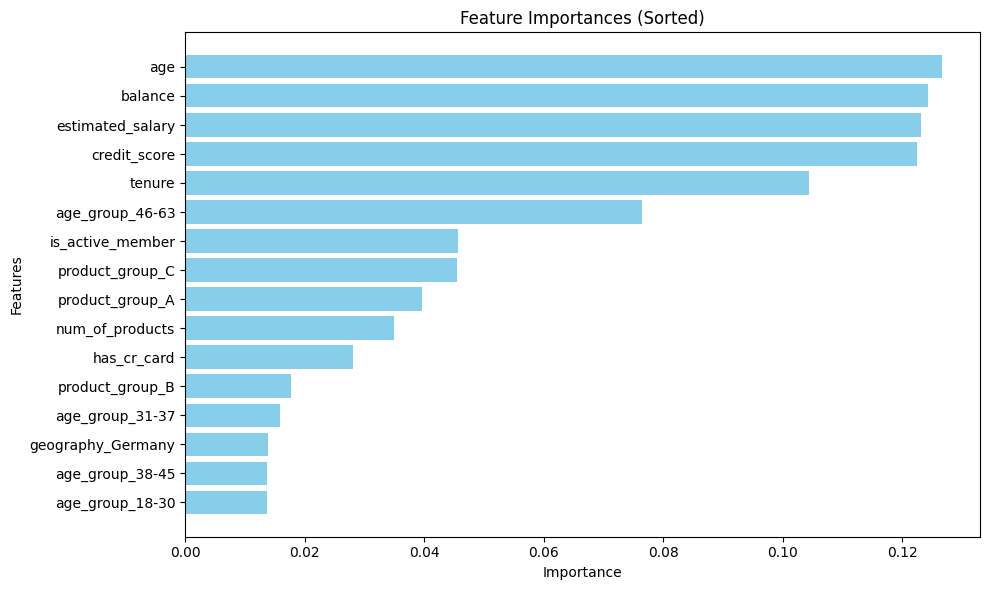

In [35]:
pipe_feat_selection.fit(X_train, y_train)
selector = pipe_feat_selection.named_steps['feat_selection']
feature_names = X_train.columns

def plot_feature_importances(selector, feature_names):
    importances = selector.estimator_.feature_importances_
    selected_features = selector.get_support()
    selected_importances = importances[selected_features]
    selected_names = np.array(feature_names)[selected_features]
    sorted_indices = selected_importances.argsort()[::-1]
    sorted_importances = selected_importances[sorted_indices]
    sorted_names = selected_names[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_names, sorted_importances, color='skyblue')
    plt.gca().invert_yaxis()  # Add this line to invert y-axis
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances (Sorted)')
    plt.tight_layout()
    plt.show()

plot_feature_importances(selector, feature_names)

In this cycle 1, due to deadline restrictions, this feature selection will be used.

On cycle 2, I will implement a stratified cross-validation for feature selection, to get a consistent performance across different data splits, getting more robust feature importance scores.

In [36]:
#Extract feature importances from selector and save in a list of feature names in order of importance. This will be later used to modelm explainability.
importances = selector.estimator_.feature_importances_
selected_features = selector.get_support()
selected_importances = importances[selected_features]
selected_names = np.array(feature_names)[selected_features]
sorted_indices = selected_importances.argsort()[::-1]
sorted_names = selected_names[sorted_indices]
features_selected_ordered_list = sorted_names.tolist()
#eatures_selected_ordered_list

In [38]:
#Inspect features selected, before Modelling:
X_train[features_selected_ordered_list][:1]

,age,balance,estimated_salary,credit_score,tenure,age_group_46-63,is_active_member,product_group_C,product_group_A,num_of_products,has_cr_card,product_group_B,age_group_31-37,geography_Germany,age_group_38-45,age_group_18-30
0,0.14,0.57,0.65,0.49,0.00,0.00,0.00,1.00,0.00,0.33,1.00,0.00,0.00,1.00,0.00,1.00


In [39]:
# Apply feature selection with pipeline (creates a np array)
X_train = pipe_feat_selection.transform(X_train)

In [40]:
X_train[:1]

array([[0.488     , 0.13513514, 0.        , 0.56825745, 0.33333333,
        1.        , 0.        , 0.64528862, 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ]])

Regarding multicollinearity, the ExtraTreesClassifier reduces the impact of it through random feature selection, handling noise and irrelevant features effectively.

Since I will be testing not only tree-based models, it makes sense to check for highly correlated features among selected features, thay may be sensitive to multicollinearity.

In this cycle 1, due to deadline restrictions, I will keep like this, and implement this in the next cycle.

# Machine Learning

## BayesSearchCV

BayesSearchCV will be used to evaluate different ML models with Cross Validation.

It uses Bayesian Optimization to find the best hyperparameters, through Exploration vs Exploitation:
- Exploration: Trying new areas of the parameter space.
- Exploitation: Focusing on areas known to give good results.

### Class balancing

Target variable classes are unbalanced. 

Models will have more difficulty getting class 1 right. So to compensate this, a greater weight will be given to this class 1 (churn), to compensate the 80/20 class distribution in the datase.

This way, the models meet business team needs: a strong balance between finding actual churners (recall) and avoiding false alarms (precision).

In [55]:
# Tree-based models will use a calculated weight ratio between classes:
calc_spweight = (y_train == 0).sum() / (y_train == 1).sum()
print(f'scale_pos_weight: {(round(calc_spweight,0))}')

# LDA Priors expects class probabilities that must sum to 1:
lda_priors = [(y_train == 0).sum() / len(y_train), (y_train == 1).sum() / len(y_train)]
print(f'priors: {(priors)}')

scale_pos_weight: 4.0
priors: [0.79625, 0.20375]


### Machine Learning Models

ML models with different approaches will be tried:
- Linear Discriminant Analysis (LDA): linear classifier, similar to Logistic Regression. It can handle class imbalance through prior probabilities adjustment. It is widely used supervised algorithms for churn prediction.
- RandomForest approach: builds multiple decision trees in parallel independently.
- XGBoost approach: builds trees sequentially, with each new tree correcting errors from previous ones. Better handles class imbalance than RF, but it is more computationally intensive.

In [61]:
lda = LinearDiscriminantAnalysis(solver='lsqr', priors=lda_priors) #priors should sum to 1.0
rf = RandomForestClassifier(n_jobs=-1, random_state=98, class_weight={0:1, 1:calc_spweight}) #gives weight 1.0 to majority class (0), and 4.0 to minority class (1)
xgb = XGBClassifier(n_jobs=-1, random_state=98, scale_pos_weight=calc_spweight) #gives weight 1.0 to majority class (0), and 4.0 to minority class (1)

In this cycle 1, due to deadline restrictions, three models will be evaluated.

In the next cycle, I will evaluate other models, like TabPFN deep learning model. It has been outperforming traditional models like XGBoost on small datasets like this (up to 10k samples). 

Its key advantages include excellent out-of-box performance without hyperparameter tuning, built-in uncertainty estimation, and automatic handling of missing values and categorical variables. 

Another interesting approach to churn would be to use survival analysis models, that estimate the time to an event, to identify when a customer would churn, but this would require time series data. 

### Hyperparameter Tuning

A hyperparameter space was created for each model, and will be used by BayesSearchCV for the exploration/exploitation process.

In [165]:
params_grid = [    
    
    {# LinearDiscriminantAnalysis params
        'classifier': [lda],
        'classifier__shrinkage': Real(0.0, 1.0),               # Similar to regularization
        'classifier__tol': Real(1e-5, 1e-3),                   # Threshold for rank estimation
    },

    {# RandomForestClassifier params
        'classifier': [rf],
        'classifier__n_estimators': Integer(20, 100),           # Number of trees in the forest
        'classifier__max_features': Categorical([2, 3]),        # Max features to consider for split
        'classifier__max_depth': Integer(2, 6),                 # Maximum depth of each tree
        'classifier__min_samples_split': Categorical([5, 10]),  # Min samples required to split
        'classifier__min_samples_leaf': Categorical([2, 4]),    # Min samples in leaf node
    },
        
    {# XGBoost params
        'classifier': [xgb],
        'classifier__n_estimators': Integer(20, 100),            # Number of boosting rounds
        'classifier__max_depth': Integer(2, 6),                  # Maximum depth of trees
        'classifier__min_child_weight': Categorical([3, 5]),     # Min sum of weights needed in child
        'classifier__subsample': Real(0.6, 0.8),                 # Fraction of samples used for tree building
        'classifier__colsample_bytree': Real(0.6, 0.8),          # Fraction of features used per tree
    }
]

In this cycle 1, due to deadline restrictions, only these parameters were tried. 

In the next one, I will evaluate more parameters that affect model complexity, to get even better fine tuning result with BayesSearchCV.

In [120]:
# Create pipeline for machine learning models. Will consider all of them.
pipe_ml_models = Pipeline([
    ('classifier', RandomForestClassifier(n_jobs=-1, random_state=98))
])

In [140]:
# Instanciate BayesSearchCV
bs_cv_best_model = BayesSearchCV(
    pipe_ml_models,
    search_spaces=params_grid,
    n_iter = 20,   # Number of parameter settings that are sampled - default=50  --> n_iter trades off runtime (less) vs quality of the solution (more).
    n_points = 2,  # Number of parameter settings to sample in parallel. default=1 --> n_points trades off optimal parameter selection (less) vs runtime (more).
    cv = 10,       # Evaluations: [ n_iter * n_points * CV] 
    scoring='f1',
    random_state=98,
    return_train_score=True, # Will be used to identify possible overfitting
    n_jobs=-1,
    verbose = 0
)
# ignore numpy compatibility issues with scikit-optimize (skopt)
warnings.filterwarnings('ignore', category=RuntimeWarning) 
# Fit, looking for the best model
bs_cv_best_model.fit(X_train, y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('classifier',
                                         RandomForestClassifier(n_jobs=-1,
                                                                random_state=98))]),
              n_iter=20, n_jobs=-1, n_points=2, random_state=98,
              return_train_score=True, scoring='f1',
              search_spaces=[{'classifier': [LinearDiscriminantAnalysis(priors=[0.79625,
                                                                                0.20375],
                                                                        solver='lsqr')],
                              'classifier__shrinkage': Real(low=0.0, high=1.0, prior='un...
                              'classifier__colsample_bytree': Real(low=0.6, high=0.8, prior='uniform', transform='normalize'),
                              'classifier__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                              'classifier__min_child_weight': Categorical(categories=(3, 5), prior=None),
                              'classifier__n_estimators': Integer(low=20, high=100, prior='uniform', transform='normalize'),
                              'classifier__subsample': Real(low=0.6, high=0.8, prior='uniform', transform='normalize')}])

In this cycle 1, due to deadline restrictions, low numbers on n_iter and n_points were used, to speed up training.

On next cycle, higher values of n_iter and a lower on n_points will be used, in order to maximize quality of solution and parameter selection.

### Evaluation Metric

F1 score will be the metric used, considering:
  - Business team needs a good balance between finding actual churners (recall) and avoiding false alarms (precision).
  - Focuses on minority class (churners) performance without being skewed by majority class dominance (unbalanced dataset: 20% churned).

In [144]:
# Check top 3 models, with its parameters, and mean train vs validation score
res_bs_cv_best_model = pd.DataFrame(bs_cv_best_model.cv_results_)
res_bs_cv_best_model[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:3]

,rank_test_score,params,mean_train_score,mean_test_score
55,1,"{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=-1, num_parallel_tree=None, random_state=98, ...), 'classifier__colsample_bytree': 0.648016171528319, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 20, 'classifier__subsample': 0.6850812057635555}",0.63,0.61
52,2,"{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=-1, num_parallel_tree=None, random_state=98, ...), 'classifier__colsample_bytree': 0.7474749957571444, 'classifier__max_depth': 4, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 23, 'classifier__subsample': 0.6640335572159929}",0.64,0.60
50,3,"{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=-1, num_parallel_tree=None, random_state=98, ...), 'classifier__colsample_bytree': 0.7014030319625949, 'classifier__max_depth': 4, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 34, 'classifier__subsample': 0.7943541880437791}",0.65,0.60


The minimal diference between mean_train_score and mean_test_score (validation) confirms that the model is not overfitting against validation data.

Use the classification_report to see the f1_score for both classes: 1(churn) and 0 (no churn):

In [145]:
# Get cross-validated predictions
y_pred_cv = cross_val_predict(bs_cv_best_model.best_estimator_, X_train, y_train, cv=10)

# Get classification report for validation performance
print('\nCross-Validation Classification Report:')
print(classification_report(y_train, y_pred_cv))


Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      6370
           1       0.51      0.75      0.61      1630

    accuracy                           0.80      8000
   macro avg       0.72      0.78      0.74      8000
weighted avg       0.84      0.80      0.81      8000



### CV Model Performance

Business expecatation: The model must be at least 55% effective in identifying true churners, while avoiding false positives.

Model performance: 
- Class 1 (Churners)     --> f1-score = 0.61 --> Model has 61% effectiveness in identifying true churners.
- Class 0 (Non-churners) --> f1-score = 0.87 --> Model has 87% effectiveness in identifying non-churners.

The minimum requirements for cycle 1 were attained. 

On next cycles, I will focus on improving the f1_score of class 1:
- New feature engineering can be done, to introduce stronger features that better distinguish class 1.
- Different stratyegies to give more weight to class 1 can be tried.
- New feature selection techniques or thresholds can be tested, to identify features more discriminative.

## Model Explainability

The model predictions will be explained to business team with SHAP (SHapley Additive exPlanations).

Among all SHAP explainers, the TreeExplainer was choosen, because it is optimized for tree-based models like XGBoost, and provides faster computation than the model-agnostic explainer (KernelExplainer).

Shap explains:
- Which features matter most
- How features affect predictions

In [146]:
# Recreate DataFrame with features selected on feature selection
X_train_feat_sel = pd.DataFrame(X_train, columns=features_selected_ordered_list)

# Get the best estimator from BayesSearchCV
best_estimator = bs_cv_best_model.best_estimator_.named_steps['classifier']

# Instantiate Shap, load the estimator, and the dataset
s = shap.TreeExplainer(best_estimator)
shap_vals = s.shap_values(X_train_feat_sel)
target_idx = 1 # 1, so right side = churn

### Summary plot

The SHAP summary plot shows how each feature impacts model predictions:

- Each dot represents one observation.
- Features are ranked by importance (top to bottom). 
    - Higher position = more important feature.
    - Longer bars = stronger overall impact

Color Interpretation:
- Red dots: High feature values. Blue dots: Low feature values

Impact Direction:
- If red dots are on right (positive SHAP): High values increase churn probability
- If blue dots are on right (negative SHAP): Low values increase churn probability

Exemple of Churn Interpretation:
- age_group_18-30: customers within this age group have lower churn probability (all blue dots are on right)
- balance: most customers with higher balance values have higher churn probability (most of red dots are on right)
- is_active_member: customers who are active memers have lower churn probability (all blue dots are on right)
- product_group_A: customers on group A (they have 3 or 4 products) have higher churn probability (all red dots are on right)

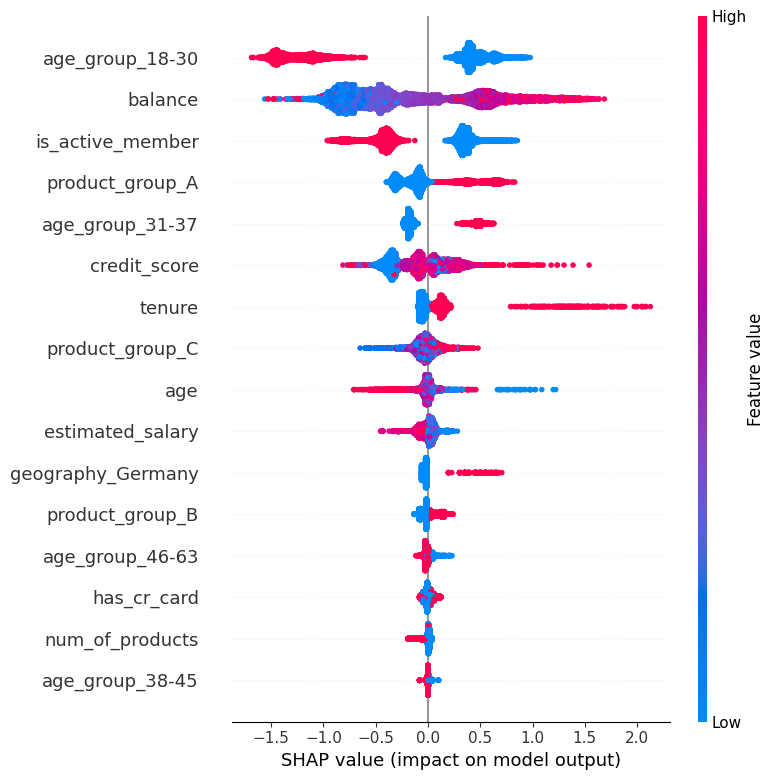

In [150]:
shap.initjs()
shap_vals = s.shap_values(X_train_feat_sel)
shap.summary_plot(shap_vals, X_train_feat_sel)

### Individual Predictions

Inspect first customer of train dataset. 

1 - What was the model prediction? (0= no churn, 1= churn)

In [151]:
# Model prediction
print(f"Model prediction for first customer is: {best_estimator.predict(X_train_feat_sel.iloc[:1])[0] }")

Model prediction for first customer is: 0


2 - What is this customer probability of churn?

In [152]:
print(f"Churn probability for first customer: {round(best_estimator.predict_proba(X_train_feat_sel.iloc[[0]])[0][1] * 100)}%")

Churn probability for first customer: 20%


3 - How this prediction was calculated by the model?

Individual Plot:
- The middle number (base value) shows the average/base prediction for all customers.

Features are arrows. Arrow length: Magnitude of impact.
- Red arrows: Push prediction toward churn (1)
- Blue arrows: Push prediction away from churn (0)

Exemple of Churn Interpretation for this customer:

- few features contributing to push toward churn. One of them is:
  - product_group_A: customers on group A (they have 3 or 4 products) have higher churn probability.

- more features pushing predictions away from churn and with greater intensity. The 2 main are: 
  - age_group_18-30: customers within this age group have lower churn probability.
  - balance: customers with low balance values have lower churn probability.

In [154]:
shap.initjs()
shap_vals_1 = s.shap_values(X_train_feat_sel[:1])
shap.force_plot(s.expected_value, shap_vals_1,feature_names=X_train_feat_sel.columns)

Plot of image above:

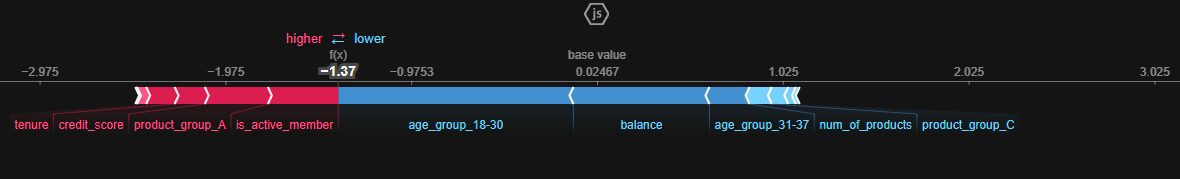

A great use of Shap is to provide the retention team with a way to consult the explanation of each customer's churn prediction from Shap. 

This way, they can approach the customer in a customized way, based on the factors that most contribute to their churn, further increasing the churn retention rate.

## Pipeline with best model

The best model evaluated was an XGBoostClassifier.

Pros:
- Handles non-linear relationships between features naturally.
- Better at handling imbalanced datasets compared to basic algorithms (scale_pos_weight parameter).
- Offers multiple hyperparameters for fine-tuning.

Cons:
- Performance deteriorates with highly imbalanced datasets (especially < 5% minority class, which is not the case).
- Requires a more attentive hyperparameter tuning.
- Works best with larger datasets than this (8k rows).

A new pipeline will be built now with the XGBoostClassifier.

It will read the raw train dataset, and apply all steps done separately up to the machine learning step.

In [155]:
# Create f1 metric, since Xgboost does not handles nativelly with it
def f1_metric_(predt, dtrain):
    y_true = dtrain.get_label()
    y_pred = (predt > 0.5).astype(int)
    return 'f1', f1_score(y_true, y_pred)

In [156]:
#Train a new XGBClassifier with same parameters of best model 
best_model = XGBClassifier(
    max_depth=4,
    n_estimators=20,
    n_jobs=-1,
    colsample_bytree= 0.648016171528319,
    min_child_weight= 3,
    subsample= 0.6850812057635555,
    random_state=98,
    eval_metric=f1_metric_
)

In [157]:
# Full Training Pipeline
pipe_train = Pipeline([
    # Rename Columns
    ('rename_features', RenameDfColumns()),
    # Filter Features
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname'])),
    # # Feature engineering
    ('feature_eng', FeatureEngineering()),
    # Data Preparation
    ('preprocessing', col_transformer_dt_prep), 
    # # Feature Selection
    ('feat_selection', pipe_feat_selection),
    # # Model Training
    ('train_classifier', best_model)           
])
#pipe_train

In [158]:
#Use X_train_raw, not touched, splitted in Data Split
print(X_train_raw.shape)
X_train_raw[:1]

(8000, 13)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,2603,15683521,Godfrey,594,Germany,Male,28,0,142574.71,2,1,0,129084.82


In [159]:
# Fit pipeline
model_pipe_trained = pipe_train.fit(X_train_raw, y_train)
#model_pipe_trained

Make predictions on test data, simulating production data.

Use X_test_raw, not touched, splitted in Data Split:

In [164]:
#predict with model
y_pred_test = model_pipe_trained.predict(X_test_raw)

# Get detailed classification metrics
print('\nClassification Report:')
print(classification_report(y_test_raw, y_pred_test))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.81      0.45      0.58       407

    accuracy                           0.87      2000
   macro avg       0.84      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



## Final Model Performance

Model performance:

Difference between f1-score of class 1 on train vs test: 0.58 vs 0.61. -> Model performs consistently across both sets.

- Class 1 (Churners)     --> f1-score = 0.58 --> Model has 58% effectiveness in identifying true churners.
- Class 0 (Non-churners) --> f1-score = 0.92 --> Model has 92% effectiveness in identifying non-churners.


## Retrain With All Data

The final model was trained using 8k rows, because 2k rows were user as test.

Now, a final model with 10k row will be trained. It has the same parameters as the best one.

The objective is to improve performance for final prediction.


In [166]:
#Use df_raw, not touched, loaded in Load Data section:
print(df_raw.shape)
df_raw.head(1)

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1


In [167]:
# Retrain a new XGBClassifier with 10k rows now, with same parameters of best model 
best_model_full = XGBClassifier(
    max_depth=4,
    n_estimators=20,
    n_jobs=-1,
    colsample_bytree= 0.648016171528319,
    min_child_weight= 3,
    subsample= 0.6850812057635555,
    random_state=98,
    eval_metric=f1_metric_
)

# Final Pipeline
pipe_full = Pipeline([
    # Rename Columns
    ('rename_features', RenameDfColumns()),
    # Filter Features
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname'])),
    # # Feature engineering
    ('feature_eng', FeatureEngineering()),
    # Data Preparation
    ('preprocessing', col_transformer_dt_prep), 
    # # Feature Selection
    ('feat_selection', pipe_feat_selection),
    # # Model Training
    ('train_classifier', best_model_full)           
])
X_full = df_raw.drop('Exited', axis=1)
y_full = df_raw.Exited

# Fit Final Pipeline
model_full = pipe_full.fit(X_full, y_full)
model_full

Pipeline(steps=[('rename_features', RenameDfColumns()),
                ('filter_features',
                 FilterFeatures(columns=['row_number', 'customer_id',
                                         'surname'])),
                ('feature_eng', FeatureEngineering()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric_scaling',
                                                                   MinMaxScaler())]),
                                                  Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'h...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=20, n_jobs=-1,
                               num_parallel_tree=None, random_state=98, ...))])

In [168]:
y_pred_full = model_full.predict(X_full)
f1_full = f1_score(y_full, y_pred_full)
print(f'F1 score on Full Dataset: {f1_full:.2f}')

F1 score on Full Dataset: 0.60


Metric similar to the one with best model pipeline one.

Save the trained pipeline model:

In [178]:
joblib.dump(model_full, '../models/pipeline_model_full.pkl', compress = 1)

['../models/pipeline_model_full.pkl']

## Final Predictions

Load final pipeline:

In [182]:
model_full = joblib.load('../models/pipeline_model_full.pkl')

Load test data, predict churn and export file with predictions.  

In [183]:
df_ans = pd.read_csv('../data/test/abandono_teste.csv', sep=';')
print(df_ans.shape)
df_ans.head(1)

(1000, 13)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08


In [184]:
# Predict
y_pred_full = model_full.predict(df_ans)

# Create final file
df_ans_final = pd.DataFrame({ 'rowNumber': df_ans['RowNumber'], 'predictedValues': y_pred_full})
print(df_ans_final.shape)
df_ans_final.head(2)

(1000, 2)


,rowNumber,predictedValues
0,10001,0
1,10002,0


In [185]:
# Inspect class proportion of predictions
df_ans_final.predictedValues.value_counts(normalize=True)

predictedValues
0   0.87
1   0.13
Name: proportion, dtype: float64

In [186]:
# Export predictions to CSV
df_ans_final.to_csv('../data/result/abandono_result.csv', index=False)

# Business and Financial Results

## Business Results

Here, the business results of this project will be shown.

Business problem:
- The financial institution has an estimated churn retention rate of 28%/year.
- A new retention goal was announced for next year, which is 40%. To achieve this, the customer retention team needs a churn prediction model.
- The model must be at least 55% effective in identifying true churners, while avoiding false positives.
- This way, the retention team will act using the model to reverse at least 80% of churns, which results in 44% retention, reaching the goal.

Business results:
- The fraud prediction model in it's first cycle delivers 58% effective in identifying true churners.
- The result expected by retention team was a model with at least 55% effectiveness, wich was attained.
- Now the project can be put into production, and the retention team can then start using it.

## Financial Results

Here, the financial results of this churn prediction model will be estimated.

Premisses:
- Model effectiveness for churners (F1-score) is 0.58.
- Company has a base of 10 million customers.
- Average estimated cost per churned customer: R$ 750 / year.
- Average estimated churn rate: 18% / year -> 1.800.000 customers/year.

Current 1 year scenario without the model:
- Estimated churn company's retention rate: 28% / year.
- Estimated churn cost: RS 972.000.000/year (72% of 1.800.000 customers * RS 750)

Current 1 year scenario using the model:
- Estimated churn company's retention rate: 46% / year (model identifies 58%, and 80% is retained). 
- Estimated churn cost: RS 729.000.000/year (54% of 1.800.000 customers * RS 750)

Estimated Savings using the model: RS 243.000.000/year.

Considering the model is on cycle 1, and there is a lot of opportunity to improve it, the result can be even greater in the future.

# Improvements for Next Cycles

**EDA:**
  - Build the analyses via Python, so that I have control over the size of the bins and can perform more detailed inspections of the data.

**Modeling:**

- Feature engineering:
  - Statistically validate using the Kruskal-Wallis test, which features from feature engineering have significant differences between groups, then decide if they may be included on project.
  - Increase the number of derived features in feature engineering, trying interactions and polynomials.
  - Running a clustering to identify natural groups of customers, and create a new feature using this labels.

- Data Preparation:
  - Replace One Hot Encoding with Ordinal, Binary and Target encodings, to reduce dataset dimensionality and support data drifts, as detailed in Data Preparation section.

- Feature Selection:
  - Since I will be testing not only tree-based models, it makes sense to check for highly correlated features among selected features, thay may be sensitive to multicollinearity.
  - Implement a stratified cross-validation for feature selection, to get a consistent performance across different data splits, getting more robust feature importance scores.

- Machine Learning:
  - Evaluate other models like TabPFN (deep learning), who has excellent out-of-box performance without hyperparameter tuning, has built-in uncertainty estimation, and has been outperforming XGBoost on small datasets like this. 
  - Hyperparameter Tuning: evaluate more model parameters that affect model complexity, to get even better fine tuning result with BayesSearchCV.
  - Improve the f1_score of class 1 with new feature engineering, class balancing and changes on feature selection, to identify more discriminative features.

**Support for retention team: (beyond model predictions):**

Model explaniability:
  - Create user-friendly interface for retention teams to access SHAP global and individual explanations. This way, they can approach the customer in a customized way, based on the factors that most contribute to their churn, further increasing the churn retention rate.
  - Build a calibrated probability model based on XGBoost (CalibratedClassifierCV) that creates reliable churn likelihood bands, enabling the retention team to optimize resource allocation based on different probability ranges of customer churn.

Churn expected date:
  - Collecting time series data, survival analysis models that estimate the time to an event could be used, to identify when a customer would churn. This would be handy, because the retention team could use different retention approaches, depending on the customer's stage. 